# <div align="center">Level 1. Titanic: Machine Learning form Disaster</div>
## <div align="center">4. Introduction to Ensembling/Stacking in Python</div>
### <div align="center"> 제작자 : 김규동 </div>
### <div align="center"> 제작 시작 : 2020. 1. 15. 17:40 PM <br> 최종 수정 : 2019. 1. 15. 19:40 PM</div>

-----------------------------------------------------------------------------------------------------------
<a id="0"></a> <br>
# 목차
1. [소개](#1)
<br><br>
1. [변수 분석, 전처리, Engineering](#2)
    1. [Feature Engineering](#3)
    1. [시각화](#4)
<br><br>
1. [앙상블 및 스택 모델](#5)
    1. [Python 클래스를 통한 도움말](#6)
    1. [예측 불가](#7)
<br><br>
1. [1단계 : 모델 생성](#8)
    1. [파라미터 이해하기](#9)
    1. [훈련 데이터 및 테스트 데이터에서 NumPy를 이용한 array 생성](#10)
    1. [1단계 예측 결과](#11)
    1. [서로 다른 분류기로부터 생성된 변수의 중요도](#12)
    1. [Plotly 산점도 그림을 통한 반응적 변수의 중요도](#13)
    1. [평균 변수의 중요도의 Plotly 막대그래프](#14)
<br><br>
1. [2단계 : 1단계 출력값으로부터의 예측](#15)
    1. [새 변수로 첫 번째 레벨 출력](#16)
    1. [2번째 수준의 훈련 데이터셋에 대한 상관관계 히트맵](#17)
    1. [XGBoost를 통한 2레벨의 학습 모델](#18)
    1. [제출파일 작성](#19)
<br><br>
1. [결과](#20)

[목차로](#0)

------------------------------------------------------------------------------------------------
<a id="1"></a> <br>
# 1. 소개

이 노트북은 기초 학습 모델, 특히 스택으로 알려진 앙상블의 변형에 대한 매우 기본적이고 단순한 입문 프라이머입니다.<br>
간단히 말하면, 1단계(베이스)로서 적층 용도를 사용하는 경우, 몇 가지 기본 분류기의 예측을 한 다음,<br>
2단계에서 다른 모델을 사용하여 이전의 1단계 예측으로부터 산출물을 예측합니다.

Kaggle의 많은 신인들이 타이타닉 데이터셋에서부터 시작하기 때문에 이 개념을 도입하는 데 있어 가장 유력한 후보지입니다.<br>
비록 많은 팀이 Kaggle Competition에서 우승한 경험은 있으나, 이 주제에 대한 알맹이가 부족한 것 같아,<br>
이 공책이 그 공백을 어느 정도 메울 수 있기를 바랍니다.

저자도 이 커널을 작성할 당시 Kaggle에 새로 들어온 사람입니다.<br>
저자가 우연히 알게 된 첫 번째 적절한 앙상블/추적 커널은 Faron의 'AllState Severity Claims competition'에 쓰여진 것이었다고 합니다.<br>
이 노트북의 자료도 Faron의 커널에서 많이 빌려온 것이라고 합니다.<br>
그가 퇴행자의 앙상블이었을 때 분류자의 앙상블을 고려하기 위해 배치되었습니다.

그의 자세한 스크립트에 대한 것은 아래 주소를 참고하기 바랍니다.

[Stacking Starter][21] : by Faron 

이제 손에 들고 있는 노트북에, 증명할 수 있고, 직관적이고, 간결한 방식으로 앙상블의 개념을 전달하기를 바랍니다.<br>
아래에 설명된 것과 정확히 동일한 앙상블 단계를 구현하는 저자의 다른 독립형 [Kaggle 커널][22]은<br>
상위 9%까지 도달할 수 있을 만큼 충분한 0.808의 공개 LB 점수를 제공합니다.<br>
그러므로 저는 그 대본을 개선하고 추가할 여지가 많다고 확신합니다.<br>
어쨌든, 제가 어떻게 개선할 수 있는지에 대한 의견을 자유롭게 남겨주길 바랍니다.

[21]: https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867
[22]: https://www.kaggle.com/arthurtok/titanic/simple-stacking-with-xgboost-0-808

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# 5개의 모델을 교차 검증하며 사용해볼 것입니다.
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

[목차로](#0)

------------------------------------------------------------------------------------------------
<a id="2"></a> <br>
# 2. 변수 분석, 전처리, Engineering

이제 우리는 대부분의 커널을 구조화된 방식과 같이 진행해 나갈 것입니다.

먼저 손에 잡히는 데이터를 살펴보고, 가능한 형상 공학적 기회를 식별하고, 어떤 범주형 특징을 수치적으로 인코딩하는 것입니다.

In [2]:
# 훈련 데이터 및 테스트 데이터 불러오기
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# passengerID를 다른 변수로 저장
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


우리의 임무는, 어떻게 해서든 범주형 변수에서 정보를 추출하는 것이라는 것입니다.

<a id="3"></a> <br>
## 2-1. Feature Engineering

여기서, Feature Engineering 아이디어에 대한 Sina의 매우 포괄적이고 잘 생각한 노트북에 크레딧이 확장되어야 하므로, 그의 작품을 확인해 보시기 바랍니다.

[Titanic Best Working Classfier][23] : by Sina


  [23]: https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier

In [3]:
full_data = [train, test]

# 저자가 별도로 추가한 몇몇 특징

## a. 이름 길이 부여
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

## b. 승객이 타이타닉에 Cabin을 가지고 있었는지 여부를 알려주는 변수
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [4]:
# Sina에 의한 Feature engineering 단계

## a. SibSp와 Parch의 결합으로 FamilySize라는 새로운 변수 생성
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [5]:
## b. FamilySize로부터 IsAlone(독신 여부)라는 새로운 변수 생성
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [6]:
## c. Embarked 열에서 모든 Null값 제거('S'라는 값으로 다 채우게 됨)
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [7]:
## d. Fare 열에서 모든 Null값 제거 및 CategoricalFare라는 새로운 변수 생성
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [8]:
## e. CagegoricalAge라는 새로운 변수 생성
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [9]:
## f. 승객 이름의 title 추출하는 함수 정의
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [10]:
## g. Title(승객 이름의 title을 포함)이라는 새로운 변수 생성
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [11]:
## h. 독특한 타이틀은 하나의 새로운 그룹인 'Rare'로 그룹화
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',
                                                 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [12]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [13]:
# 변수 선택
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

변수들을 청소하고 관련 정보를 추출하고 범주형 열을 삭제했으니, 이제 우리의 기계 학습 모델에 적합한 형식이 되게 만들어야 합니다.<br>
그러나 진행하기 전에 변환된 데이터 세트의 간단한 상관 관계 및 분포도를 생성하여 그 양상을 관찰할 필요가 있습니다.
<a id="4"></a> <br>
## 2-2. 시각화

In [14]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


**피어슨 상관관계 히트맵**

한 변수가 다른 변수들과 얼마나 관련이 있는지 알아보기 위해 변수의 상관 관계를 몇 가지 생성해 봅시다.<br>
이를 위해 우리는 다음과 같이 매우 편리하게 히트맵을 그릴 수 있는 Seaborn 패키지를 이용할 것입니다.

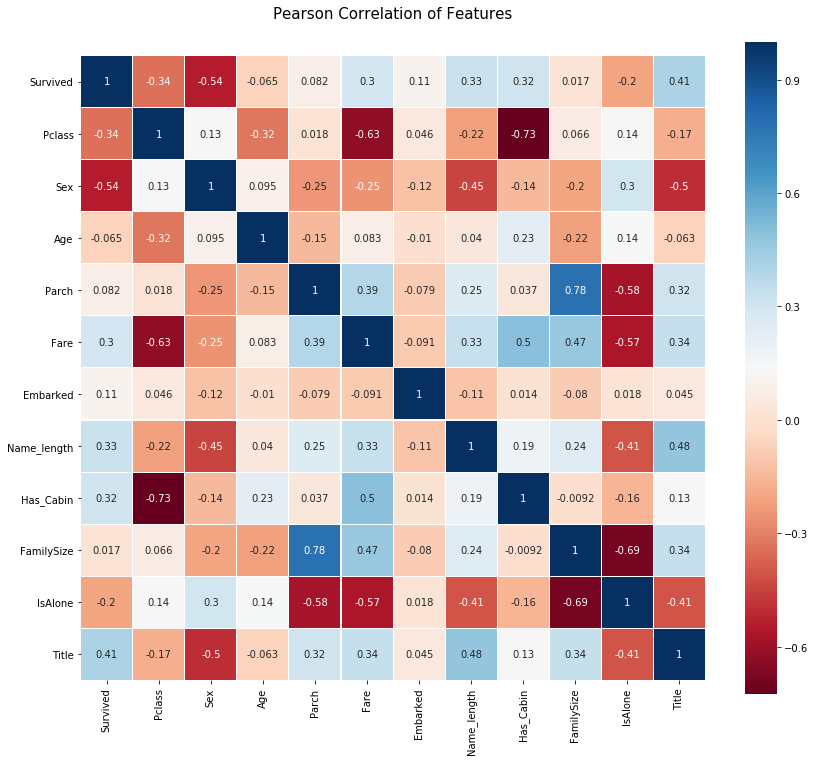

In [15]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

** 그래프 보기 **

피어스 상관관계 그림이 우리에게 말해 줄 수 있는 한 가지는 '서로 강하게 상관되는 특징들이 너무 많지 않다'는 것입니다.<br>
이러한 양상은 학습 모델에 제공하는 관점에서 좋은 것으로, 훈련 데이터에는 중복되거나 불필요한 데이터가 별로 없다는 것을 의미합니다.
또 우리는 각 변수가 어떤 독특한 정보를 가지고 있다는 것을 알아챌 수 있습니다.<br>
다음은 FamilySize와 Parch(부모와 자녀)의 두 가지 상관관계가 있습니다. 연습을 위해 두 가지 특징을 모두 그대로 둘 것입니다.

** Pairplots **

마지막으로 한 변수에서 다른 변수로의 데이터 분포를 관찰할 수 있는 몇 가지 페어 플롯을 생성해 봅시다.<br>
다시 한번 우리는 Seaborn을 사용할 것입니다.

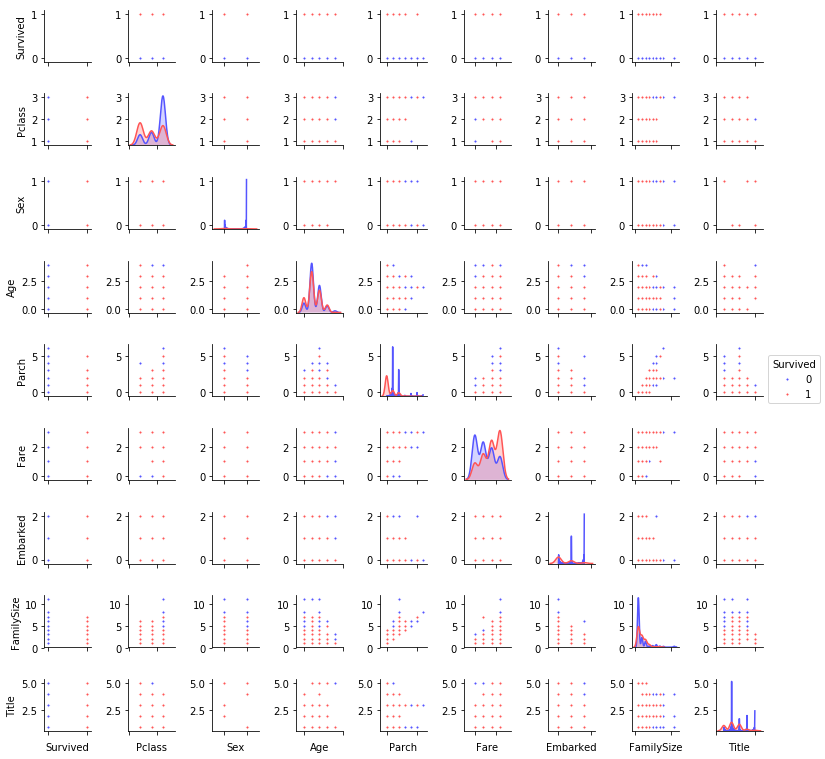

In [16]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

[목차로](#0)

------------------------------------------------------------------------------------------------
<a id="5"></a> <br>
# 3. 앙상블 및 스택 모델

우리는 마침내 이 노트의 핵심에 도달했습니다.

스택 앙상블 만들기!

<a id="6"></a> <br>
## 3-1. Python 클래스를 통한 도움말

여기서 우리는 우리에게 더 편리하게 하기 위해 파이썬의 수업을 사용하게 됩니다.

프로그래밍을 처음 시작한 사람에게는 일반적으로 OOP(Object-Oriented Programming)와 함께 클래스가 사용되는 것을 듣습니다.<br>
요컨대, 클래스는 객체(구식 핍에 대한 변수)를 작성하기 위한 일부 코드/프로그램을 확장하고 해당 클래스에 특정한 기능과 방법을 구현하는 데 도움이 됩니다.

아래 코드 섹션에서는 기본적으로 모든 Sklearn 분류기에 공통적으로 사용되는 내장 방법(예: 훈련 데이터 예측 및 적합)<br>
을 확장할 수 있는 *SklearnHelper* 클래스를 작성합니다.<br>
따라서 우리가 다섯 개의 다른 분류기를 호출하고 싶다면, 동일한 방법을 다섯 번 쓸 필요가 없기 때문에 중복성을 배제합니다.

In [17]:
# 나중에 유용하게 쓰일 몇 가지 유용한 매개 변수
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

In [18]:
# Sklearn 분류기를 확장하는 클래스 생성
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

이미 이것을 알고 있는 사람들을 위해서, 그러나 이전에 파이썬에서 클래스나 오브젝트를 만들지 않은 사람들을 위해서,<br>
저는 위에 주어진 코드가 무엇을 하는지 설명해 드리겠습니다.

기본 분류기를 만들 때, 저는 sklearn library에 이미 있는 모델만 사용할 것이고, 따라서 그것을 위한 수업만 연장할 것입니다.

**def init** : 클래스에 대한 기본 생성자를 호출하기 위한 Python 표준.<br>
즉, 객체(분류기)를 만들려면 clf(어떤 스키어 분류기를 원하는지), seed(랜덤 시드), param(분류기용 매개변수)의 파라미터를 부여해야 합니다.

나머지 코드는 단순히 sklearn 분류기 내에 이미 존재하는 해당 방법을 부르는 클래스의 방법일 뿐입니다.<br>
기본적으로, 우리는 다양한 Sklearn 분류기를 확장하기 위해 래퍼 클래스를 만들었고,<br>
이것은 우리가 스택러에 여러 학습자를 구현할 때 같은 코드를 반복해서 쓸 필요가 없도록 도와줍니다.

<a id="7"></a> <br>
## 3-2. 예측 불가

소개 섹션에서 위에서 언급한 바와 같이,<br>
스택은 2단계 모델에 대한 교육을 위해 기본 분류기의 예측을 입력으로 사용한다.

그러나 단순히 전체 훈련 데이터에 기초 모델을 학습시키고,<br>
전체 테스트 데이터에 대한 예측을 생성한 다음,<br>
2차 훈련을 위해 기본 모델을 출력할 수는 없습니다.

이는 기본 모델 예측이 이미 테스트 데이터셋을 "보았기" 때문에 이러한 예측을 제공할 때 오버 피팅의 위험을 초래합니다.

In [19]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

[목차로](#0)

------------------------------------------------------------------------------------------------
<a id="8"></a> <br>
# 4. 1단계 : 모델 생성

이제 첫 번째 레벨 분류로 다섯 가지 학습 모델을 준비해봅시다.<br>
이러한 모델은 모두 Sklearn 라이브러리를 통해 편리하게 호출할 수 있으며 다음과 같이 나열되어 있습니다.

 1. Random Forest classifier
 2. Extra Trees classifier
 3. AdaBoost classifer
 4. Gradient Boosting classifer
 5. Support Vector Machine(SVM)

<a id="9"></a> <br>
## 4-1. 파라미터 이해하기

완전성을 위해 여기에 나열할 매개변수를 간략하게 요약하면 다음과 같습니다.

**n_jobs** : 교육 프로세스에 사용되는 코어 수. -1로 설정하면 모든 코어가 사용됩니다.

**n_estimators** : 학습 모델의 분류 트리 수(기본값당 10개로 설정됨)

**max_deep** : 트리의 최대 깊이 또는 노드를 확장해야 하는 크기. 너무 높게 설정하면 나무가 너무 깊이 자랄 위험이 있으므로 주의하세요.

**verbose** : 학습 과정 중에 텍스트를 출력할지 여부 제어. 0 값은 모든 텍스트를 억제하는 반면 3 값은 반복할 때마다 트리 학습 프로세스를 출력합니다.

공식 Sklearn 웹 사이트를 통해 전체 설명을 확인하세요.<br>
거기서 당신은 당신이 가지고 놀 수 있는 많은 다른 유용한 매개변수들이 있다는 것을 알게 될 것입니다.

In [20]:
# 해당 분류기에 대한 매개 변수 입력

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

게다가 OOP 프레임워크 내의 개체와 클래스에 대해 언급했으므로,<br>
이제 앞에서 정의한 Helper Sklearn 클래스를 통해 5개의 학습 모델을 나타내는 5개의 개체를 생성해 봅시다.

In [21]:
# 5개의 객체 생성
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

<a id="10"></a> <br>
## 4-2. 훈련 데이터 및 테스트 데이터에서 NumPy를 이용한 array 생성

좋습니다. 위에서 첫 번째 계층 기본 모델을 준비했으니,<br>
이제 NumPy array를 원래 데이터 프레임에서 다음과 같이 생성하여 분류기에 입력하기 위한 훈련 및 테스트 데이터를 준비할 수 있습니다.

In [22]:
# Seagate 모델에 공급할 훈련, 테스트 및 타깃(Survived) 데이터 프레임의 축소된 배열 생성
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creats an array of the test data

<a id="11"></a> <br>
## 4-3. 1단계 예측 결과

우리는 이제 훈련과 테스트 데이터를 5개의 기본 분류기에 입력하고<br>
앞에서 정의한 예측 기능을 사용하여 첫 번째 수준의 예측을 생성할 것입니다.

아래 코드가 실행될 때까지 몇 분 정도 기다리세요.

In [23]:
# OOF 훈련 및 테스트 데이터에 대한 예측 생성(이 결과는 새로운 변수로 사용됨)
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

Training is complete


<a id="12"></a> <br>
## 4-4. 서로 다른 분류기로부터 생성된 변수의 중요도

첫 번째 수준의 분류기를 배웠으니 우리는 sklearn 모델의 매우 민첩한 특징을 활용할 수 있고,<br>
이는 훈련 및 테스트 데이터셋의 다양한 특징들을 하나의 매우 단순한 코드 라인으로 출력할 수 있습니다.

Sklearn 설명서에 따르면
대부분의 분류자는 **.feature_importions_**을 입력하기만 하면 피쳐 가져오기 기능을 반환하는 속성으로 내장되어 있습니다.<br>
그러므로 우리는 우리의 함수 귀사를 통해 매우 유용한 속성을 호출하고 다음과 같은 특징적 수입원을 표시할 것입니다.

In [24]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[ 0.12723212  0.19828616  0.02805507  0.02163451  0.07182503  0.02378753
  0.11025597  0.0644748   0.06650686  0.01344234  0.27449962]
[ 0.12065052  0.38124091  0.02717613  0.01654814  0.05659005  0.02800833
  0.04717079  0.08336801  0.04587051  0.02090829  0.1724683 ]
[ 0.03   0.008  0.014  0.068  0.04   0.01   0.696  0.014  0.05   0.004
  0.066]
[ 0.07690205  0.02876392  0.1097725   0.03425264  0.09209596  0.05440531
  0.40467443  0.01572553  0.07170219  0.02805027  0.0836552 ]


그러나 아직 변수의 중요도를 완전히 할당하고 저장하는 방법을 알아내지 못했습니다.<br>
따라서 위의 코드에서 값을 출력한 다음 아래와 같이 Python 목록에 복사하여 붙여넣을 것이다.

In [25]:
# 저자의 결과값
"""
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371,
               0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157,
               0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008,
                0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854,
               0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]
"""

# 본인의 결과값
rf_features = [0.12744467, 0.19878228, 0.03280782, 0.02026083, 0.07062299, 0.02371953,
               0.10598414, 0.06506545, 0.06885129, 0.01377609, 0.27268491]
et_features = [0.12268921, 0.37993562, 0.02912038, 0.01654575, 0.05556577, 0.02857685,
               0.04689155, 0.08409832, 0.04365948, 0.02129523, 0.17162184]
ada_features = [0.03, 0.01, 0.02, 0.062, 0.034, 0.008, 0.696, 0.012, 0.05, 0.004, 0.074]
gb_features = [0.07202989, 0.03244964, 0.10381478, 0.0322107,  0.08839205, 0.06451757,
               0.42717722, 0.02277748, 0.06645172, 0.02087609, 0.06930285]

Plotly 패키지를 통해 쉽게 플롯할 수 있도록 형상 중요 데이터가 들어 있는 목록에서 데이터 프레임을 생성합니다.

In [26]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame({'features': cols,
                                  'Random Forest feature importances': rf_features,
                                  'Extra Trees feature importances': et_features,
                                  'AdaBoost feature importances': ada_features,
                                  'Gradient Boost feature importances': gb_features})

<a id="13"></a> <br>
## 4-5. Plotly 산점도 그림을 통한 반응적 변수의 중요도

저는 이 시점에서 대화형 Plotly 패키지를 사용하여 다음과 같이 "산점도"를 호출하여,<br>
분산 플롯을 통해 다른 분류기의 형상 가져오기 값을 시각화할 것입니다.

In [27]:
# Scatter plot for Random Forest feature importances
trace = go.Scatter(y = feature_dataframe['Random Forest feature importances'].values,
                   x = feature_dataframe['features'].values,
                   mode='markers',
                   marker=dict(sizemode = 'diameter', sizeref = 1, size = 25,
                               color = feature_dataframe['Random Forest feature importances'].values,
                               colorscale='Portland', showscale=True),
                   text = feature_dataframe['features'].values)
data = [trace]

layout= go.Layout(autosize= True,
                  title= 'Random Forest Feature Importance',
                  hovermode= 'closest',
                  yaxis=dict(title='Feature Importance', ticklen= 5, gridwidth= 2),
#                 xaxis= dict(title='Pop', ticklen= 5, zeroline= False, gridwidth= 2),
                  showlegend= False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [28]:
# Scatter plot for Extra Trees feature importances
trace = go.Scatter(y = feature_dataframe['Extra Trees feature importances'].values,
                   x = feature_dataframe['features'].values,
                   mode='markers',
                   marker=dict(sizemode = 'diameter', sizeref = 1, size = 25,
                               color = feature_dataframe['Extra Trees feature importances'].values,
                               colorscale='Portland', showscale=True),
                   text = feature_dataframe['features'].values)
data = [trace]

layout= go.Layout(autosize= True,
                  title='Extra Trees feature importances',
                  hovermode= 'closest',
                  yaxis=dict(title='Feature Importance', ticklen= 5, gridwidth= 2),
#                 xaxis= dict(title='Pop', ticklen= 5, zeroline= False, gridwidth= 2),
                  showlegend= False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [29]:
# Scatter plot for AdaBoost feature importances
trace = go.Scatter(y = feature_dataframe['AdaBoost feature importances'].values,
                   x = feature_dataframe['features'].values,
                   mode='markers',
                   marker=dict(sizemode = 'diameter', sizeref = 1, size = 25,
                               color = feature_dataframe['AdaBoost feature importances'].values,
                               colorscale='Portland', showscale=True),
                   text = feature_dataframe['features'].values)
data = [trace]

layout= go.Layout(autosize= True,
                  title='AdaBoost feature importances',
                  hovermode= 'closest',
                  yaxis=dict(title='Feature Importance', ticklen= 5, gridwidth= 2),
#                 xaxis= dict(title='Pop', ticklen= 5, zeroline= False, gridwidth= 2),
                  showlegend= False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [30]:
# Scatter plot for Gradient Boost feature importances
trace = go.Scatter(y = feature_dataframe['Gradient Boost feature importances'].values,
                   x = feature_dataframe['features'].values,
                   mode='markers',
                   marker=dict(sizemode = 'diameter', sizeref = 1, size = 25,
                               color = feature_dataframe['Gradient Boost feature importances'].values,
                               colorscale='Portland', showscale=True),
                   text = feature_dataframe['features'].values)
data = [trace]

layout= go.Layout(autosize= True,
                  title='Gradient Boost feature importances',
                  hovermode= 'closest',
                  yaxis=dict(title='Feature Importance', ticklen= 5, gridwidth= 2),
#                 xaxis= dict(title='Pop', ticklen= 5, zeroline= False, gridwidth= 2),
                  showlegend= False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

이제 모든 형상 가져오기 평균을 계산하여 형상 중요도 데이터 프레임에 새 열로 저장해 둡시다.

In [31]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.127445,0.122689,0.03,0.072030,0.088041
1,Sex,0.198782,0.379936,0.01,0.032450,0.155292
2,Age,0.032808,0.029120,0.02,0.103815,0.046436


<a id="14"></a> <br>
## 4-6. 평균 변수의 중요도의 Plotly 막대그래프

모든 분류기에서 평균 피쳐 중요성을 파악한 후 다음과 같이 Plotly 막대 그래프로 표시할 수 있습니다.

In [32]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(x= x,
               y= y,
               width = 0.5,
               marker=dict(color = feature_dataframe['mean'].values,
                           colorscale='Portland',
                           showscale=True,
                           reversescale = False),
               opacity=0.6)]

layout= go.Layout(autosize= True,
                  title='Barplots of Mean Feature Importance',
                  hovermode='closest',
#                 xaxis= dict(title='Pop', ticklen=5, zeroline=False, gridwidth=2,),
                  yaxis=dict(title='Feature Importance', ticklen=5, gridwidth=2),
                  showlegend= False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

[목차로](#0)

------------------------------------------------------------------------------------------------
<a id="15"></a> <br>
# 5. 2단계 : 1단계 출력값으로부터의 예측

<a id="16"></a> <br>
## 5-1. 새 변수로 첫 번째 레벨 출력

이제 우리의 1단계 예측을 얻었으니, 본질적으로 다음 분류기의 훈련 데이터로 사용될 새로운 기능 집합을 구축하는 것이라고 생각할 수 있습니다.

아래 코드에 따라, 우리는 새로운 칼럼으로 이전의 분류자들로부터의 1단계 예측을 가지고 있고, 우리는 이것에 대한 다음 분류자를 훈련시키고 있습니다.

In [33]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
                                       'ExtraTrees': et_oof_train.ravel(),
                                       'AdaBoost': ada_oof_train.ravel(),
                                       'GradientBoost': gb_oof_train.ravel()})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


<a id="17"></a> <br>
## 5-2. 2번째 수준의 훈련 데이터셋에 대한 상관관계 히트맵

In [34]:
data = [go.Heatmap(z=base_predictions_train.astype(float).corr().values,
                   x=base_predictions_train.columns.values,
                   y=base_predictions_train.columns.values,
                   colorscale='Viridis',
                   showscale=True,
                   reversescale = True)]
py.iplot(data, filename='labelled-heatmap')

서로 더 상관없는 훈련된 모델들이 더 좋은 점수를 내는 것의 장점에 대한 기사들과 Kaggle 경쟁상 수상자들의 이야기들이 꽤 있었습니다.

In [35]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

이제 x_train과 x_test로 1단계 열차와 테스트 예측에 모두 연계하고 참여했으니 이제 2단계 학습 모델을 장착할 수 있게 되었습니다.

<a id="18"></a> <br>
## 5-3. XGBoost를 통한 2레벨의 학습 모델

여기서 우리는 강화된 나무 학습 모델인 XGBoost를 위해 아주 유명한 library를 선택합니다.<br>
이는 대규모로 증강된 트리 알고리즘을 최적화하기 위해 만들어졌습니다.

알고리즘에 대한 자세한 내용은 [공식 문서][24]를 확인하세요.

  [24]: https://xgboost.readthedocs.io/en/latest/

어쨌든 우리는 XGBC 분류기를 불러 1차 열차 및 목표 데이터에 맞추고 학습된 모델을 사용하여 다음과 같이 시험 데이터를 예측할 것입니다.

In [36]:
gbm = xgb.XGBClassifier(n_estimators=2000, max_depth= 4, min_child_weight= 2,
                        gamma=0.9, subsample=0.8, colsample_bytree=0.8, # learning_rate = 0.02,
                        objective= 'binary:logistic', nthread= -1, scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

모델에 사용된 XGBoost 매개 변수를 간단히 요약했습니다.

**max_deep**: 트리의 깊이. 너무 높게 설정하면 오버핏의 위험이 발생할 수 있으므로 주의하세요.

**gamma** : 트리의 리프 노드에서 추가 파티션을 만드는 데 필요한 최소 손실 감소. 크기가 클수록 알고리즘은 보수적일 것입니다.

**eta** : 각 부스팅 단계에서 사용되어 오버피팅 방지

<a id="19"></a> <br>
## 5-4. 제출파일 작성

마침내 모든 1단 및 2단 모델을 교육하고 적합하게 만들었고,<br>
이제 다음과 같이 예측을 타이타닉 대회에 제출할 수 있는 적절한 형식으로 출력할 수 있습니다.

In [37]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

[목차로](#0)

------------------------------------------------------------------------------------------------
<a id="20"></a> <br>
# 6. 결과

**추가 개선을 위한 단계**

마지막으로 상기 단계는 앙상블 스택러를 생성하는 매우 간단한 방법임을 유의해야 합니다.<br>
가장 높은 수준의 카글 대회에서 만들어진 앙상블에 대해 들어보실 수 있습니다.<br>
이 대회는 누적된 분류기와 2단계 이상의 스택 레벨을 포함합니다.

점수를 높이기 위해 취할 수 있는 몇 가지 추가 단계는 다음과 같습니다.

1. 최적의 매개변수 값을 찾기 위해 모델을 교육할 때 교차 검증 전략을 구현합니다.
2. 학습을 위한 보다 다양한 기본 모델을 소개합니다. 결과가 상관없는 것일수록 최종 점수는 더 좋습니다.

저는 이 노트북이 학습 모델을 쌓기 위한 작업 대본을 소개하는 데 다소 도움이 되었다고 생각합니다. 다시 한 번 Faron과 Sina에게 감사를 표합니다.<br>
일반적으로 스택 또는 앙상블에 대한 기타 우수한 자료는 MLWave 웹사이트에서 볼 수 있습니다. [Kaggle 앙상블 가이드][25]

감사합니다.

  [25]: http://mlwave.com/kaggle-ensembling-guide/